### import

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import numpy as np
import matplotlib.pyplot as plt

sys.path.append("../Lib")
from mcmc import MetropolisGauss
from particle import ParticleDimer
from plot import plot_dimer_energy_with_data

### MCMC

### model

In [3]:
model = ParticleDimer()

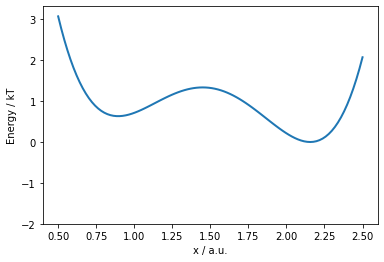

In [5]:
_=model.plot_dimer_energy()

### data

In [ ]:
def plot_trajectory(etraj, traj):
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].plot(etraj)
    axes[0].set_xlabel('timestep')
    axes[0].set_ylabel('energy')
    dtraj = np.sqrt((traj[:, 2] - traj[:, 0])**2 + (traj[:, 3] - traj[:, 1])**2)
    axes[1].plot(dtraj)
    axes[1].set_xlabel('timestep')
    axes[1].set_ylabel('dimer distance')    
    plt.tight_layout()
    return dtraj

In [ ]:
model = ParticleDimer()

In [ ]:
nsteps = 500000
stride = 10
noise=0.02
burnin=100000
d_closed = 1.0
d_open = 2.0

In [ ]:
# sample closed
x0 = model.init_positions(d_closed)
sampler_closed = MetropolisGauss(model, x0, noise=noise, burnin=burnin, stride=stride)
sampler_closed.run(nsteps)
plot_trajectory(sampler_closed.etraj, sampler_closed.traj)

In [ ]:
model.draw_config(sampler_closed.traj[-1], dimercolor='blue', alpha=0.8);

In [ ]:
# sample open
x0 = model.init_positions(d_open)
sampler_open = MetropolisGauss(model, x0, noise=noise, burnin=burnin, stride=stride)
sampler_open.run(nsteps)
plot_trajectory(sampler_open.etraj, sampler_open.traj)

In [ ]:
model.draw_config(sampler_open.traj[-1], dimercolor='red', alpha=0.8)

In [ ]:
x_open=sampler_open.traj
x_closed=sampler_closed.traj
x_open_dis=model.dimer_distance(x_open)
x_closed_dis=model.dimer_distance(x_closed)

In [ ]:
x_brute=np.vstack((x_open,x_closed))
x_brute_dis=model.dimer_distance(x_brute)
x_brute.shape

In [ ]:
def plot_dimer_energy_with_data(model, x, axis=None):
    counts, bins = np.histogram(x, bins = 200 )
    anchors = (bins[1:] + bins[:-1]) / 2
    probs = counts / np.sum(counts)

    anchors = anchors[np.where(probs > 0.0001)]
    probs = probs[np.where(probs > 0.0001)]

    f = -np.log(probs)
    fn = f - np.min(f)
    plt.scatter(anchors, fn)  
    """ Plots the dimer energy to the standard figure """
    d_scan = np.linspace(0.5, 2.5, 100)
    E_scan = model.dimer_energy_distance(d_scan)
    E_scan -= E_scan.min()

    if axis is None:
        axis = plt.gca()
    #plt.figure(figsize=(5, 4))
    axis.plot(d_scan, E_scan, linewidth=2)
    axis.set_xlabel('x / a.u.')
    axis.set_ylabel('Energy / kT')
    axis.set_ylim(E_scan.min() - 2.0, E_scan[int(E_scan.size / 2)] + 2.0)


    return d_scan, E_scan

In [ ]:
x,E=plot_dimer_energy_with_data(model,x_open_dis)

In [ ]:
x,E=plot_dimer_energy_with_data(model,x_closed_dis)

In [ ]:
x,E=plot_dimer_energy_with_data(model,x_brute_dis)

In [ ]:
plt.hist(sampler_closed.etraj, 50, histtype='stepfilled', color='blue', alpha=0.2);
plt.hist(sampler_closed.etraj, 50, histtype='step', color='blue', linewidth=2);
plt.hist(sampler_open.etraj, 50, histtype='stepfilled', color='red', alpha=0.2);
plt.hist(sampler_open.etraj, 50, histtype='step', color='red', linewidth=2);
plt.xlabel('Energy / kT')
plt.yticks([])
plt.ylabel('Probability')

In [ ]:
plt.figure(figsize=(10, 4))
ax1 = plt.subplot2grid((1, 3), (0, 0), colspan=2)
ax2 = plt.subplot2grid((1, 3), (0, 2))
ax1.plot(model.dimer_distance(sampler_closed.traj), color='blue', alpha=0.7)
ax1.plot(model.dimer_distance(sampler_open.traj), color='red', alpha=0.7)
ax1.set_xlim(0, 20000)
ax1.set_ylim(0.5, 2.5)
ax1.set_xlabel('Time / steps')
ax1.set_ylabel('Dimer distance / a.u.')
ax2.hist(model.dimer_distance(sampler_closed.traj), 30, orientation='horizontal', histtype='stepfilled', color='blue', alpha=0.2);
ax2.hist(model.dimer_distance(sampler_closed.traj), 30, orientation='horizontal', histtype='step', color='blue', linewidth=2);
ax2.hist(model.dimer_distance(sampler_open.traj), 30, orientation='horizontal', histtype='stepfilled', color='red', alpha=0.2);
ax2.hist(model.dimer_distance(sampler_open.traj), 30, orientation='horizontal', histtype='step', color='red', linewidth=2);
ax2.set_xticks([])
ax2.set_yticks([])
ax2.set_ylim(0.5, 2.5)
ax2.set_xlabel('Probability')

In [ ]:
np.save('dimer_data\dimer_data_36p',x_brute)